In [ ]:
pip install tensorflow pandas numpy matplotlib yahoo_fin sklearn

     |████████████████████████████████| 81 kB 5.1 MB/s 
     |████████████████████████████████| 87 kB 6.6 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 
     |████████████████████████████████| 127 kB 35.9 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13503 sha256=449628d6250ed9c2b48dfdda168014234e5cdf4baeb697bed693ca80c9037c6d
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=0d4822b5b1670251f39f35b2acdda4ac7a5a60cfafa4ac600058a3ec0af5afe7
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=0a43b68de6d90a6afade9cabee2d05f1d8702b8b06c1bb5ba15a47f9f0b90430
  Stored in directory: /root/.cac

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

In [ ]:
pip install requests_html

In [ ]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [ ]:
def shuffle_in_unison(a, b):
    
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    
    
    if isinstance(ticker, str):
       
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
     
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    
    result = {}
    
    result['df'] = df.copy()

    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
      
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        
        result["column_scaler"] = column_scaler
    
    df['future'] = df['adjclose'].shift(-lookup_step)

    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
   
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
   
    result['last_sequence'] = last_sequence
    
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
       
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
           
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    
    dates = result["X_test"][:, -1, -1]
   
    result["test_df"] = result["df"].loc[dates]
    
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
  
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [ ]:

def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [ ]:
import os
import time
from tensorflow.keras.layers import LSTM


N_STEPS = 50

LOOKUP_STEP = 100

SCALE = True
scale_str = f"sc-{int(SCALE)}"

SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"

SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"

TEST_SIZE = 0.2

FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]

date_now = time.strftime("%Y-%m-%d")

N_LAYERS = 2

CELL = LSTM

UNITS = 256

DROPOUT = 0.4

BIDIRECTIONAL = False

LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 50
# Facebook market
ticker = "FB"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [ ]:

if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [ ]:

data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

data["df"].to_csv(ticker_data_filename)

model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/50
28/28 [==============================] - 19s 562ms/step - loss: 0.0125 - mean_absolute_error: 0.1028 - val_loss: 0.0027 - val_mean_absolute_error: 0.0552

Epoch 00001: val_loss improved from inf to 0.00271, saving model to results/2021-07-29_FB-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-100-layers-2-units-256.h5
Epoch 2/50
28/28 [==============================] - 15s 527ms/step - loss: 0.0032 - mean_absolute_error: 0.0542 - val_loss: 0.0022 - val_mean_absolute_error: 0.0409

Epoch 00002: val_loss improved from 0.00271 to 0.00221, saving model to results/2021-07-29_FB-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-100-layers-2-units-256.h5
Epoch 3/50
28/28 [==============================] - 14s 504ms/step - loss: 0.0028 - mean_absolute_error: 0.0486 - val_loss: 0.0021 - val_mean_absolute_error: 0.0424

Epoch 00003: val_loss improved from 0.00221 to 0.00215, saving model to results/2021-07-29_FB-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-100-layers-2-units-256.h5

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
    

In [ ]:
def get_final_df(model, data):
    

    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
  
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    
    test_df.sort_index(inplace=True)
    final_df = test_df
    
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    
                                    )
    
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                              
                                    )
    return final_df

In [ ]:
def predict(model, data):
   
    last_sequence = data["last_sequence"][-N_STEPS:]
   
    last_sequence = np.expand_dims(last_sequence, axis=0)
 
    prediction = model.predict(last_sequence)

    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [ ]:

model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [ ]:

loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)

if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [ ]:

final_df = get_final_df(model, data)

In [ ]:
future_price = predict(model, data)

In [ ]:
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)

total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()

total_profit = total_buy_profit + total_sell_profit

profit_per_trade = total_profit / len(final_df)

In [ ]:
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)

total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()

total_profit = total_buy_profit + total_sell_profit

profit_per_trade = total_profit / len(final_df)

In [ ]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 100 days is 420.12$
huber_loss loss: 0.002015833742916584
Mean Absolute Error: 31.95929601287021
Accuracy score: 0.8175519630484989
Total buy profit: 4424.207670211792
Total sell profit: -875.9628467559814
Total profit: 3548.2448234558105
Profit per trade: 8.194560793200486


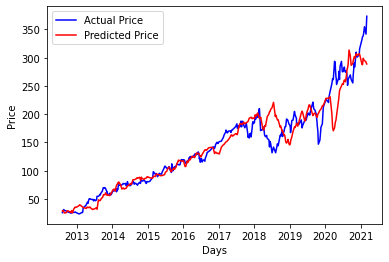

In [ ]:
plot_graph(final_df)

In [ ]:
from keras.models import load_model

model.save('mymodel.h5')